# Credit Risk Data Exploration

This notebook demonstrates comprehensive data exploration techniques for credit risk datasets.

## Objectives:
- Load and examine credit risk datasets
- Perform data quality assessment
- Conduct exploratory data analysis (EDA)
- Identify patterns and relationships
- Generate insights for model development

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add src to path and import custom modules
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
from data_loader import CreditDataLoader
from lending_club_preprocessing import LendingClubPreprocessor
from feature_engineering import FeatureEngineer

# Set up plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Configure pandas display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Data Loading and Initial Inspection

In [11]:
# Initialize data loader
lc_dir = r"../data/"
loader = CreditDataLoader(data_path=lc_dir)

# The loader will find the 'accepted' csv inside the directory
datasets = loader.load_lending_club(accepted_only=True)
accepted_df = datasets['accepted']

print("--- Raw Data: Missing Values Analysis ---")
raw_missing = accepted_df.isnull().sum()
raw_missing_pct = (raw_missing / len(accepted_df)) * 100
missing_df_raw = pd.DataFrame({
    'Missing Count': raw_missing,
    'Missing %': raw_missing_pct
}).sort_values('Missing %', ascending=False)

print(f"Total columns with missing values: {len(missing_df_raw[missing_df_raw['Missing Count'] > 0])}")
print("Top 20 columns with most missing values (raw data):")
display(missing_df_raw.head(20))

INFO:data_loader:Loaded Lending Club accepted: (2260701, 151)


--- Raw Data: Missing Values Analysis ---
Total columns with missing values: 150
Top 20 columns with most missing values (raw data):


,Missing Count,Missing %
member_id,2260701,100.000000
orig_projected_additional_accrued_interest,2252050,99.617331
hardship_reason,2249784,99.517097
hardship_payoff_balance_amount,2249784,99.517097
hardship_last_payment_amount,2249784,99.517097
payment_plan_start_date,2249784,99.517097
hardship_type,2249784,99.517097
hardship_status,2249784,99.517097
hardship_start_date,2249784,99.517097
deferral_term,2249784,99.517097


In [19]:
display(missing_df_raw.head)

<bound method NDFrame.head of                                             Missing Count   Missing %
member_id                                         2260701  100.000000
orig_projected_additional_accrued_interest        2252050   99.617331
hardship_reason                                   2249784   99.517097
hardship_payoff_balance_amount                    2249784   99.517097
hardship_last_payment_amount                      2249784   99.517097
...                                                   ...         ...
total_rec_int                                          33    0.001460
disbursement_method                                    33    0.001460
hardship_flag                                          33    0.001460
debt_settlement_flag                                   33    0.001460
id                                                      0    0.000000

[151 rows x 2 columns]>

In [12]:
# Clean + feature engineer
prep = LendingClubPreprocessor(include_pricing_features=False)
df = prep.prepare_accepted(accepted_df)

print(f"Successfully loaded and prepared data. Shape: {df.shape}")
print(f"Default rate: {df['default'].mean():.2%}")

Successfully loaded and prepared data. Shape: (1345750, 116)
Default rate: 20.01%


In [13]:
# Display first few rows
print("First 5 rows:")
display(df.head())

print("\nDataset info:")
df.info()

First 5 rows:


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,disbursement_method,mths_since_last_delinq_missing,mths_since_last_record_missing,mths_since_last_major_derog_missing,revol_util_missing,dti_missing,annual_inc_missing,default,fico_avg,credit_history_len_months,pmt_to_inc,log_annual_inc
0,3600.0,3600.0,3600.0,36 months,123.03,10+ years,MORTGAGE,55000.0,Not Verified,2015-12-01,n,debt_consolidation,PA,5.91,0.0,2003-08-01,675.0,679.0,1.0,30.0,0.0,7.0,0.0,2765.0,0.297,13.0,w,564.0,560.0,0.0,30.0,Individual,NaN,NaN,NaN,0.0,722.0,144904.0,2.0,2.0,0.0,1.0,21.0,4981.0,36.0,3.0,3.0,722.0,34.0,9300.0,3.0,1.0,4.0,4.0,20701.0,1506.0,37.2,0.0,0.0,148.0,128.0,3.0,3.0,1.0,4.0,69.0,4.0,69.0,2.0,2.0,4.0,2.0,5.0,3.0,4.0,9.0,4.0,7.0,0.0,0.0,0.0,3.0,76.9,0.0,0.0,0.0,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,0,0,0,0,0,677.0,147.996058,0.026843,10.915107
1,24700.0,24700.0,24700.0,36 months,820.28,10+ years,MORTGAGE,65000.0,Not Verified,2015-12-01,n,small_business,SD,16.06,1.0,1999-12-01,715.0,719.0,4.0,6.0,0.0,22.0,0.0,21470.0,0.192,38.0,w,699.0,695.0,0.0,0.0,Individual,NaN,NaN,NaN,0.0,0.0,204396.0,1.0,1.0,0.0,1.0,19.0,18005.0,73.0,2.0,3.0,6472.0,29.0,111800.0,0.0,0.0,6.0,4.0,9733.0,57830.0,27.1,0.0,0.0,113.0,192.0,2.0,2.0,4.0,2.0,NaN,0.0,6.0,0.0,5.0,5.0,13.0,17.0,6.0,20.0,27.0,5.0,22.0,0.0,0.0,0.0,2.0,97.4,7.7,0.0,0.0,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,0,1,1,0,0,0,0,717.0,191.984231,0.151436,11.082158
2,20000.0,20000.0,20000.0,60 months,432.66,10+ years,MORTGAGE,63000.0,Not Verified,2015-12-01,n,home_improvement,IL,10.78,0.0,2000-08-01,695.0,699.0,0.0,0.0,0.0,6.0,0.0,7869.0,0.562,18.0,w,704.0,700.0,0.0,0.0,Joint App,71000.0,13.85,Not Verified,0.0,0.0,189699.0,0.0,1.0,0.0,4.0,19.0,10827.0,73.0,0.0,2.0,2081.0,65.0,14000.0,2.0,5.0,1.0,6.0,31617.0,2737.0,55.9,0.0,0.0,125.0,184.0,14.0,14.0,5.0,101.0,NaN,10.0,NaN,0.0,2.0,3.0,2.0,4.0,6.0,4.0,7.0,3.0,6.0,0.0,0.0,0.0,0.0,100.0,50.0,0.0,0.0,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,1,1,1,0,0,0,0,697.0,183.968463,0.082411,11.050906
4,10400.0,10400.0,10400.0,60 months,289.91,3 years,MORTGAGE,104433.0,Source Verified,2015-12-01,n,major_purchase,PA,25.37,1.0,1998-06-01,695.0,699.0,3.0,12.0,0.0,12.0,0.0,21929.0,0.645,35.0,w,704.0,700.0,0.0,0.0,Individu


Dataset info:
<class 'pandas.core.frame.DataFrame'>
Index: 1345750 entries, 0 to 2260697
Columns: 116 entries, loan_amnt to log_annual_inc
dtypes: datetime64[ns](2), float64(95), int64(7), object(12)
memory usage: 1.2+ GB


In [14]:
# Basic statistics
print("Descriptive statistics:")
display(df.describe())

Descriptive statistics:


,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,mths_since_last_delinq_missing,mths_since_last_record_missing,mths_since_last_major_derog_missing,revol_util_missing,dti_missing,annual_inc_missing,default,fico_avg,credit_history_len_months,pmt_to_inc,log_annual_inc
count,1.345750e+06,1.345750e+06,1.345750e+06,1.345750e+06,1.345750e+06,1345750,1.345735e+06,1.345747e+06,1345747,1.345750e+06,1.345750e+06,1.345746e+06,1.345750e+06,1.345750e+06,1.345747e+06,1.345747e+06,1.345750e+06,1.344888e+06,1.345747e+06,1.345750e+06,1.345750e+06,1.345672e+06,1.345750e+06,2.544500e+04,25442.000000,1.345747e+06,1.277462e+06,1.277462e+06,537275.000000,537276.000000,537276.000000,537276.000000,523089.000000,5.372760e+05,464802.000000,537276.000000,537276.000000,537276.000000,537223.000000,1.277462e+06,537276.000000,537275.000000,537275.000000,1.297708e+06,1.277440e+06,1.283853e+06,1.283084e+06,1.345672e+06,1.345747e+06,1.239443e+06,1.277461e+06,1.277461e+06,1.277462e+06,1.297708e+06,1.284775e+06,318976.000000,1.170978e+06,449897.000000,1.277462e+06,1.277462e+06,1.277462e+06,1.289148e+06,1.277462e+06,1.277462e+06,1.277462e+06,1.277461e+06,1.277462e+06,1.289148e+06,1.227586e+06,1.277462e+06,1.277462e+06,1.277462e+06,1.277308e+06,1.283441e+06,1.344837e+06,1.345701e+06,1.277462e+06,1.297708e+06,1.297708e+06,1.277462e+06,18317.000000,18318.000000,18318.000000,18318.000000,18318.000000,18318.000000,17995.000000,18318.000000,18318.000000,18318.000000,18318.000000,6542.000000,5754.0,1.345750e+06,1.345750e+06,1.345750e+06,1.345750e+06,1.345750e+06,1345750.0,1.345750e+06,1.345750e+06,1.345747e+06,1.345750e+06,1.345750e+06
mean,1.441646e+04,1.440789e+04,1.438353e+04,4.379823e+02,7.480592e+04,2015-06-05 05:49:40.545867008,1.815677e+01,3.177663e-01,1999-03-03 05:07:44.827043712,6.961734e+02,7.001735e+02,6.574354e-01,1.700127e+01,1.200056e+01,1.159325e+01,2.152515e-01,1.557179e+04,5.181255e-01,2.498099e+01,6.772451e+02,6.601043e+02,1.712825e-02,1.148562e+01,1.174401e+05,18.894042,5.044039e-03,2.487351e+02,1.411355e+05,1.050773,2.793155,0.776565,1.743201,19.586906,3.586713e+04,71.421435,1.421158,3.005543,5537.667765,58.176411,3.279122e+04,1.093576,1.609195,2.312860,4.693163e+00,1.348764e+04,1.018620e+04,5.994082e+01,9.060157e-03,1.489069e+01,1.258012e+02,1.814821e+02,1.311523e+01,7.854151e+00,1.670870e+00,2.381665e+01,39.652090,6.712872e+00,35.804117,5.096144e-01,3.643008e+00,5.643846e+00,4.734529e+00,8.101835e+00,8.568641e+00,8.279227e+00,1.461131e+01,5.592998e+00,1.163973e+01,8.203091e-04,3.419280e-03,8.889110e-02,2.179046e+

## 2. Data Quality Assessment

In [15]:
# Perform comprehensive data quality check
quality_report = loader.basic_data_quality_check(df, 'default')

print("=== DATA QUALITY REPORT ===")
print(f"Dataset shape: {quality_report['shape']}")
print(f"Total missing values: {quality_report['missing_values']}")
print(f"Duplicate rows: {quality_report['duplicate_rows']}")
print(f"Default rate: {quality_report['target_rate']:.2%}")

print("\nTarget distribution:")
for value, count in quality_report['target_distribution'].items():
    print(f"  {value}: {count} ({count/sum(quality_report['target_distribution'].values()):.1%})")

=== DATA QUALITY REPORT ===
Dataset shape: (1345750, 116)
Total missing values: 38364705
Duplicate rows: 0
Default rate: 20.01%

Target distribution:
  0: 1076458 (80.0%)
  1: 269292 (20.0%)


In [20]:
# Check for missing values
missing_data = df.isnull().sum()
missing_pct = (missing_data / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing %': missing_pct
}).sort_values('Missing %', ascending=False)

print("Missing values by column:")
display(missing_df[missing_df['Missing Count'] > 0])

Missing values by column:


,Missing Count,Missing %
deferral_term,1339996,99.572432
sec_app_mths_since_last_major_derog,1339208,99.513877
sec_app_revol_util,1327755,98.662827
revol_bal_joint,1327433,98.638900
sec_app_chargeoff_within_12_mths,1327432,98.638826
sec_app_collections_12_mths_ex_med,1327432,98.638826
sec_app_open_act_il,1327432,98.638826
sec_app_num_rev_accts,1327432,98.638826
sec_app_earliest_cr_line,1327432,98.638826
sec_app_inq_last_6mths,1327432,98.638826


## 3. Target Variable Analysis

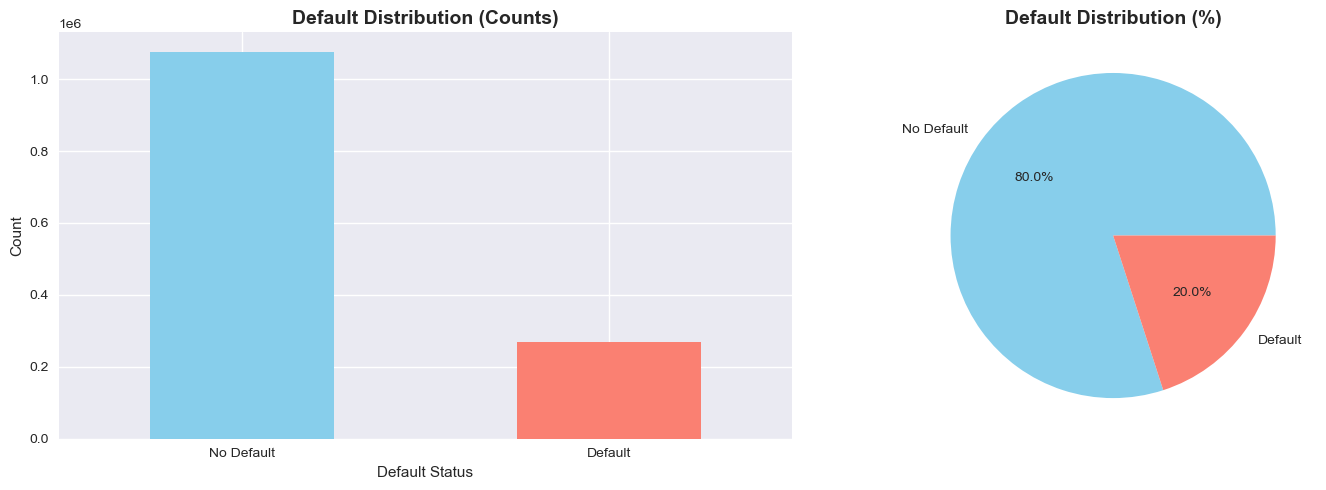

Class imbalance ratio: 4.0:1


In [21]:
# Target variable distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Count plot
df['default'].value_counts().plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
ax1.set_title('Default Distribution (Counts)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Default Status')
ax1.set_ylabel('Count')
ax1.set_xticklabels(['No Default', 'Default'], rotation=0)

# Pie chart
df['default'].value_counts().plot(kind='pie', ax=ax2, autopct='%1.1f%%', 
                                  labels=['No Default', 'Default'],
                                  colors=['skyblue', 'salmon'])
ax2.set_title('Default Distribution (%)', fontsize=14, fontweight='bold')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio: {df['default'].value_counts()[0] / df['default'].value_counts()[1]:.1f}:1")

## 4. Feature Distribution Analysis

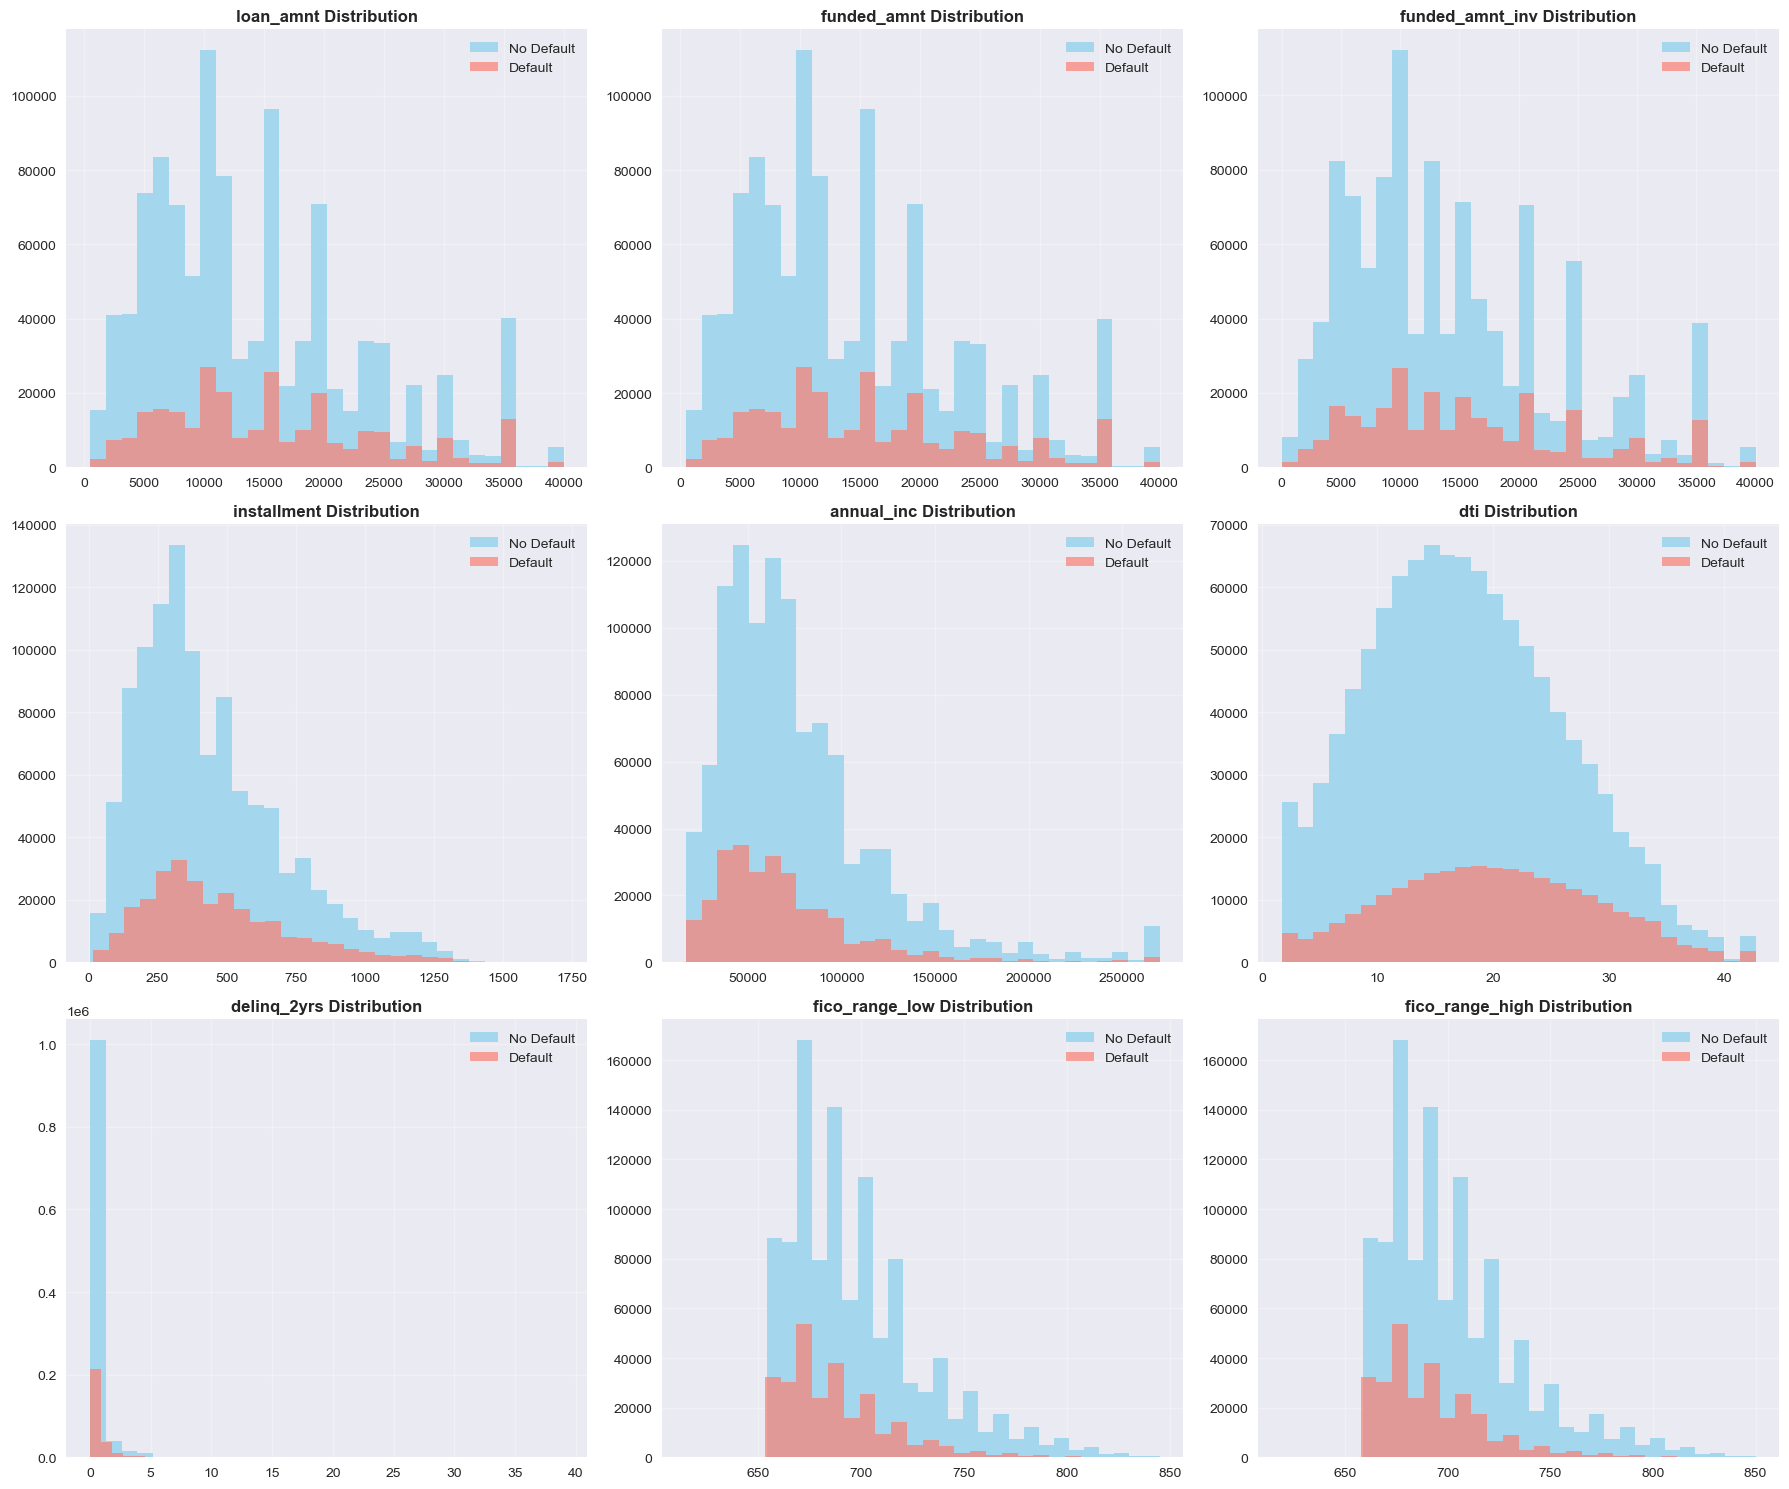

In [22]:
# Numerical features distribution
numerical_cols = df.select_dtypes(include=[np.number]).columns.drop('default')

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_cols):
    if idx < len(axes):
        # Distribution by default status
        df[df['default']==0][col].hist(bins=30, alpha=0.7, label='No Default', 
                                       color='skyblue', ax=axes[idx])
        df[df['default']==1][col].hist(bins=30, alpha=0.7, label='Default', 
                                       color='salmon', ax=axes[idx])
        axes[idx].set_title(f'{col} Distribution', fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Feature Relationships and Correlations

In [23]:
# Initialize visualizer
viz = RiskVisualizer()

# Plot correlation heatmap
correlation_fig = viz.plot_correlation_heatmap(df, figsize=(12, 10))
plt.show()

NameError: name 'RiskVisualizer' is not defined

In [ ]:
# Correlation with target variable
target_corr = df.corr()['default'].sort_values(key=abs, ascending=False)
target_corr = target_corr.drop('default')  # Remove self-correlation

print("Correlation with default (sorted by absolute value):")
for feature, corr in target_corr.items():
    print(f"{feature:25s}: {corr:6.3f}")

In [ ]:
# Visualize top correlations with target
top_corr_features = target_corr.head(6)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, (feature, corr) in enumerate(top_corr_features.items()):
    # Box plot by default status
    df.boxplot(column=feature, by='default', ax=axes[idx])
    axes[idx].set_title(f'{feature}\n(Correlation: {corr:.3f})', fontweight='bold')
    axes[idx].set_xlabel('Default Status')

plt.tight_layout()
plt.show()

## 6. Risk Segmentation Analysis

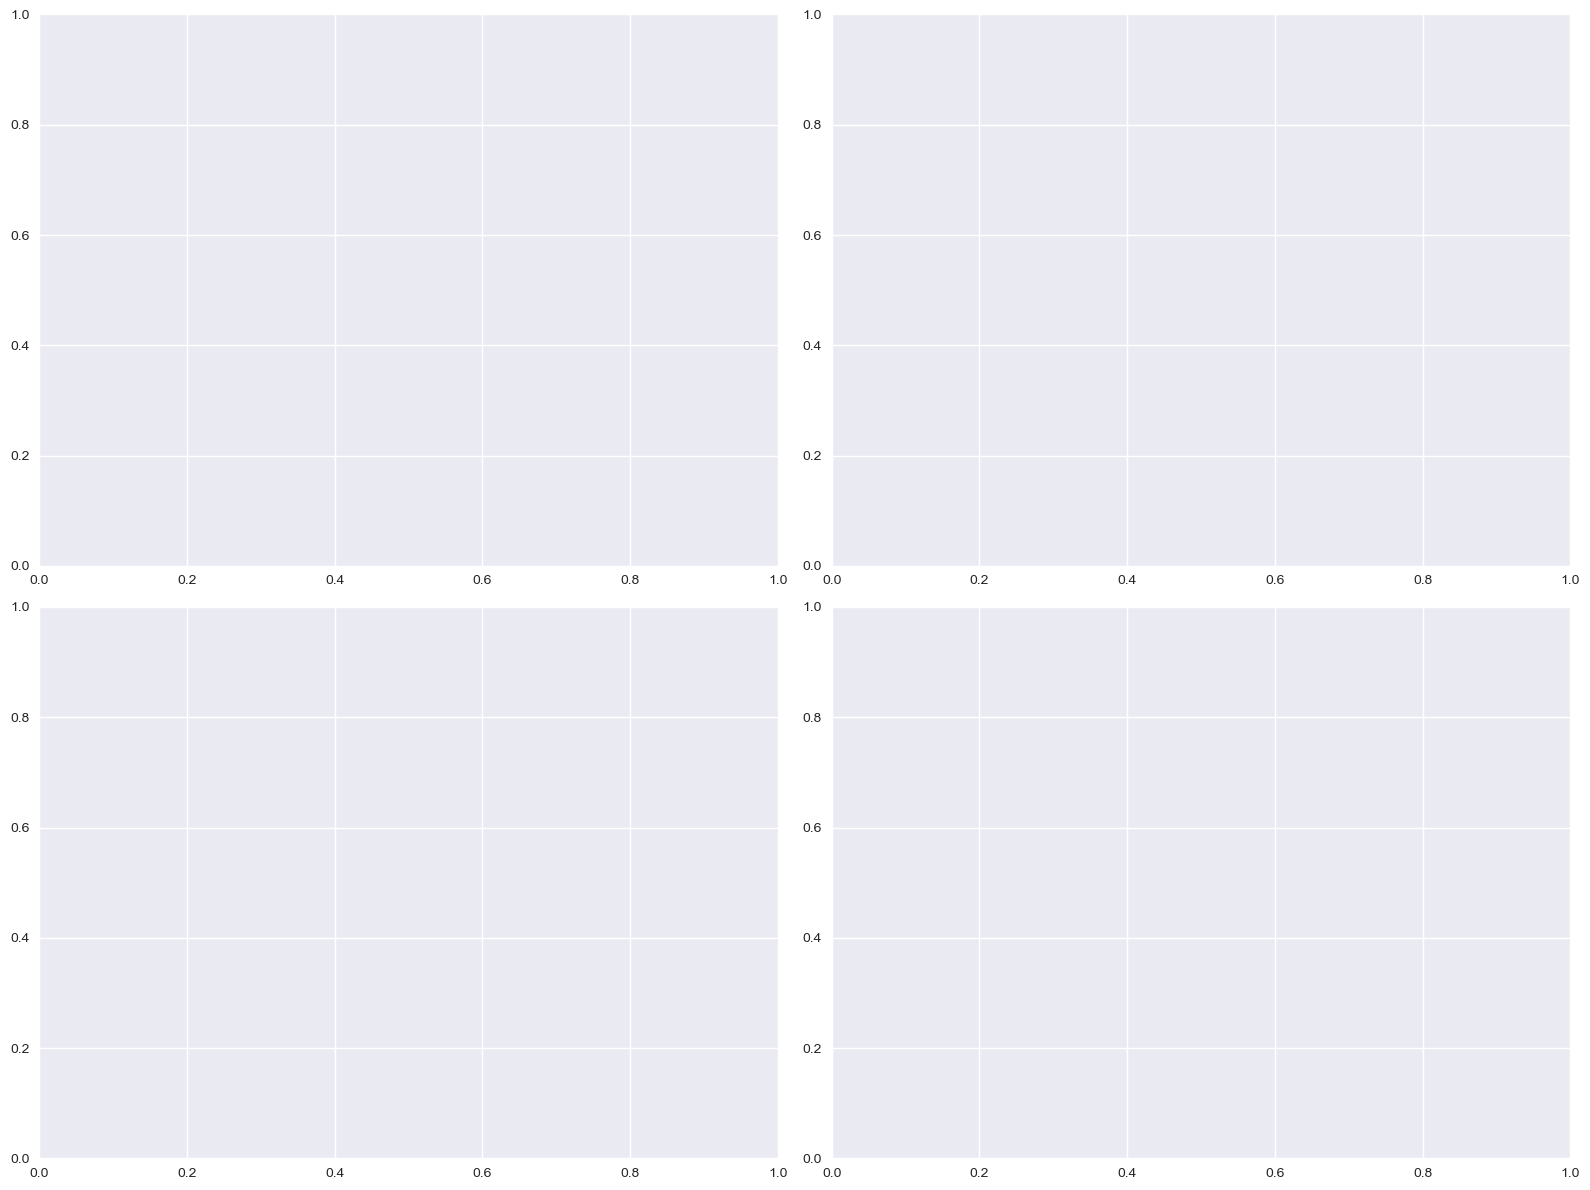

In [24]:
# Analyze default rates by risk segments
key_features = ['credit_score', 'debt_to_income', 'age', 'income']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for idx, feature in enumerate(key_features):
    if feature in df.columns:
        # Create risk bins
        df[f'{feature}_bin'] = pd.qcut(df[feature], q=10, precision=2, duplicates='drop')
        
        # Calculate default rates by bin
        bin_stats = df.groupby(f'{feature}_bin')['default'].agg(['count', 'mean']).reset_index()
        bin_stats.columns = [f'{feature}_bin', 'count', 'default_rate']
        
        # Plot default rates
        x_pos = range(len(bin_stats))
        bars = axes[idx].bar(x_pos, bin_stats['default_rate'], 
                            color='lightcoral', alpha=0.7)
        axes[idx].set_title(f'Default Rate by {feature}', fontweight='bold')
        axes[idx].set_ylabel('Default Rate')
        axes[idx].set_xlabel(f'{feature} Bins')
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels([f'Q{i+1}' for i in x_pos], rotation=45)
        axes[idx].grid(True, alpha=0.3)
        
        # Add value labels
        for i, bar in enumerate(bars):
            height = bar.get_height()
            axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                          f'{height:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 7. Advanced Analytics

In [25]:
# Create risk score based on key features
def calculate_risk_score(row):
    """Simple risk scoring function for demonstration."""
    score = 0
    
    # Credit score component (lower is worse)
    if row['credit_score'] < 600:
        score += 40
    elif row['credit_score'] < 700:
        score += 20
    
    # Debt-to-income component
    if row['debt_to_income'] > 0.4:
        score += 30
    elif row['debt_to_income'] > 0.3:
        score += 15
    
    # Age component (very young or old)
    if row['age'] < 25 or row['age'] > 65:
        score += 10
    
    # Late payment component
    if row['num_late_payments'] > 2:
        score += 20
    elif row['num_late_payments'] > 0:
        score += 10
    
    return score

# Calculate risk scores
df['risk_score'] = df.apply(calculate_risk_score, axis=1)

# Analyze risk score performance
risk_bins = pd.cut(df['risk_score'], bins=5, labels=['Low', 'Low-Med', 'Medium', 'Med-High', 'High'])
df['risk_category'] = risk_bins

risk_analysis = df.groupby('risk_category')['default'].agg(['count', 'sum', 'mean']).round(3)
risk_analysis.columns = ['Total', 'Defaults', 'Default_Rate']
risk_analysis['Default_Rate_Pct'] = (risk_analysis['Default_Rate'] * 100).round(1)

print("Risk Score Performance:")
display(risk_analysis)

KeyError: 'credit_score'

NameError: name 'risk_analysis' is not defined

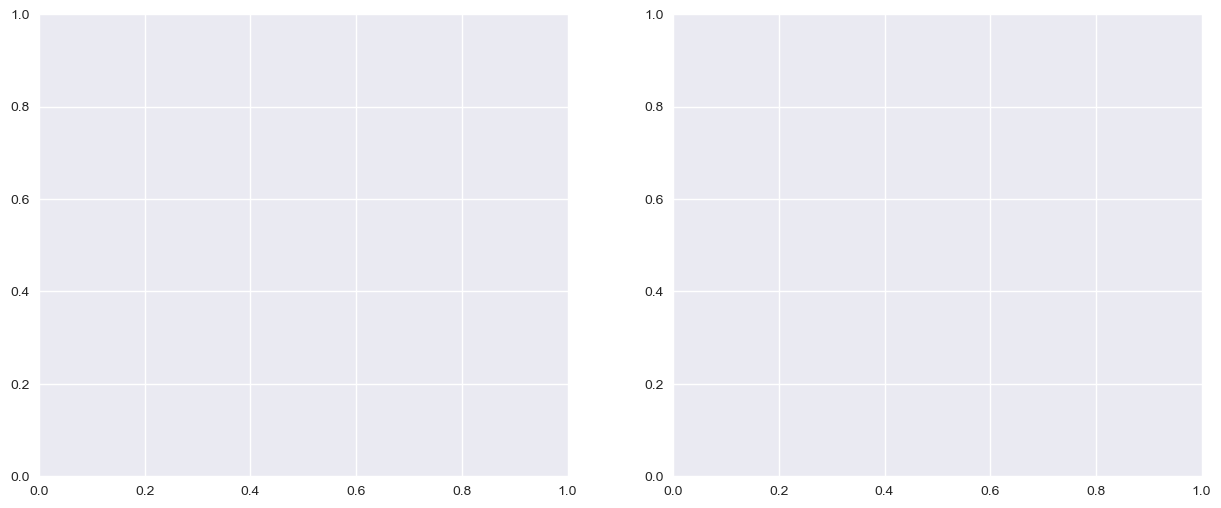

In [26]:
# Visualize risk score performance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Default rates by risk category
risk_analysis['Default_Rate'].plot(kind='bar', ax=ax1, color='lightcoral', alpha=0.7)
ax1.set_title('Default Rate by Risk Category', fontsize=14, fontweight='bold')
ax1.set_ylabel('Default Rate')
ax1.set_xlabel('Risk Category')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Volume by risk category
risk_analysis['Total'].plot(kind='bar', ax=ax2, color='lightblue', alpha=0.7)
ax2.set_title('Volume by Risk Category', fontsize=14, fontweight='bold')
ax2.set_ylabel('Count')
ax2.set_xlabel('Risk Category')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Key Insights and Recommendations

In [27]:
print("=== KEY INSIGHTS FROM DATA EXPLORATION ===")
print()

# Dataset characteristics
print(f"1. Dataset Overview:")
print(f"   - Total observations: {len(df):,}")
print(f"   - Features: {len(df.columns)-1}")
print(f"   - Default rate: {df['default'].mean():.2%}")
print(f"   - Class imbalance: {df['default'].value_counts()[0]/df['default'].value_counts()[1]:.1f}:1")
print()

# Feature insights
print(f"2. Most Predictive Features (by correlation):")
for i, (feature, corr) in enumerate(target_corr.head(5).items()):
    print(f"   {i+1}. {feature}: {corr:.3f}")
print()

# Risk segmentation insights
print(f"3. Risk Segmentation Performance:")
low_risk_rate = risk_analysis.loc['Low', 'Default_Rate']
high_risk_rate = risk_analysis.loc['High', 'Default_Rate']
print(f"   - Low risk default rate: {low_risk_rate:.2%}")
print(f"   - High risk default rate: {high_risk_rate:.2%}")
print(f"   - Risk discrimination: {high_risk_rate/low_risk_rate:.1f}x higher")
print()

print(f"4. Recommendations for Model Development:")
print(f"   - Address class imbalance using techniques like SMOTE or class weighting")
print(f"   - Focus feature engineering on top predictive variables")
print(f"   - Consider ensemble methods for better performance")
print(f"   - Implement proper cross-validation for model selection")
print(f"   - Monitor model calibration for probability accuracy")

=== KEY INSIGHTS FROM DATA EXPLORATION ===

1. Dataset Overview:
   - Total observations: 1,345,750
   - Features: 115
   - Default rate: 20.01%
   - Class imbalance: 4.0:1

2. Most Predictive Features (by correlation):


NameError: name 'target_corr' is not defined

## Next Steps

Based on this exploration, the next notebooks will cover:

1. **Feature Engineering** (`02_feature_engineering.ipynb`):
   - Advanced feature transformations
   - Interaction terms creation
   - Missing value imputation strategies

2. **Model Development** (`03_model_development.ipynb`):
   - Multiple algorithm comparison
   - Hyperparameter optimization
   - Model validation and selection

3. **Risk Analysis** (`04_risk_analysis.ipynb`):
   - Portfolio risk calculations
   - Regulatory capital estimation
   - Stress testing scenarios